### Random Forest

In [1]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
import warnings
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [23]:
df = pd.read_csv('../data/full_final_UFO.csv')

In [24]:
df.columns.values

array(['Unnamed: 0', 'datetime', 'city', 'state', 'country', 'shape',
       'duration (seconds)', 'duration (hours/min)', 'comments',
       'date posted', 'latitude', 'longitude ', 'date_pd', 'time_pd',
       'days_lapsed_after_sighting', 'dow_sighting', 'Month_sighting',
       'hour_sighting', 'label', 'phase', 'phaseid', 'index', 'STATE',
       'EVENT_TYPE', 'Extreme_Weather', 'Proximity to USAFB'],
      dtype=object)

In [25]:
new_df = df.drop(['Unnamed: 0', 'city','duration (hours/min)','latitude','longitude ','phaseid','index','STATE','EVENT_TYPE'], axis=1)
new_df['date_pd'] = pd.to_datetime(new_df['date_pd'])

In [5]:
new_df[:5]

,datetime,state,country,shape,duration (seconds),comments,date posted,date_pd,time_pd,days_lapsed_after_sighting,dow_sighting,Month_sighting,hour_sighting,label,phase,Extreme_Weather,Proximity to USAFB
0,10/10/1984 5:00,tx,us,circle,60.0,2 experience with unkown,4/18/2012,1984-10-10,5:00,10052,Wednesday,10,5,0,Full Moon,1,175.555426
1,10/10/1984 12:00,mi,us,other,120.0,translucent football seen over city airport,10/7/2003,1984-10-10,12:00,6936,Wednesday,10,12,0,Full Moon,0,284.580647
2,10/10/1984 22:00,ny,us,formation,20.0,Saw a hugh object in sky with lights intermitt...,8/10/1999,1984-10-10,22:00,5417,Wednesday,10,22,0,Full Moon,0,81.344695
3,10/10/1988 18:00,wi,us,triangle,600.0,A silent black triangular object with no light...,8/7/2007,1988-10-10,18:00,6875,Monday,10,18,0,New Moon,0,187.550150
4,10/10/1988 21:00,me,us,unknown,120.0,I&#39m still afraid to look at the sky at night.,1/10/2009,1988-10-10,21:00,7397,Monday,10,21,0,New Moon,0,115.328167


#### EDA

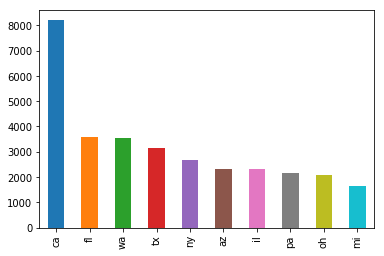

In [6]:
new_df['state'].value_counts()[:10].plot(kind='bar')

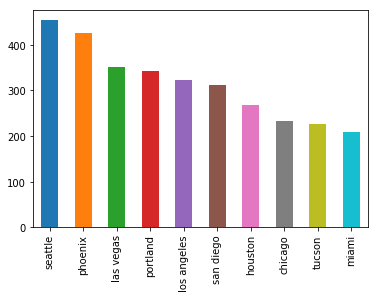

In [7]:
df['city'].value_counts()[:10].plot(kind='bar')

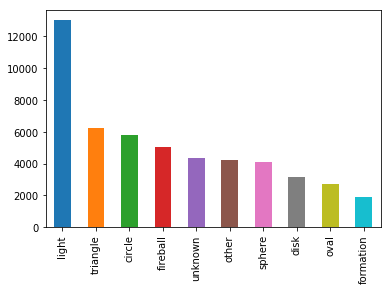

In [8]:
new_df['shape'].value_counts()[:10].plot(kind='bar')

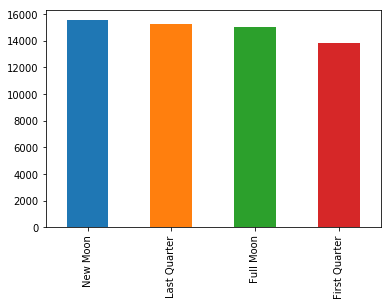

In [9]:
new_df['phase'].value_counts().plot(kind='bar')

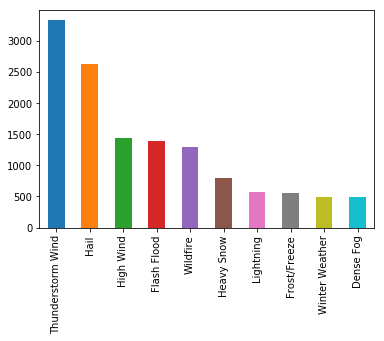

In [10]:
df['EVENT_TYPE'].value_counts()[:10].plot(kind='bar')
show()

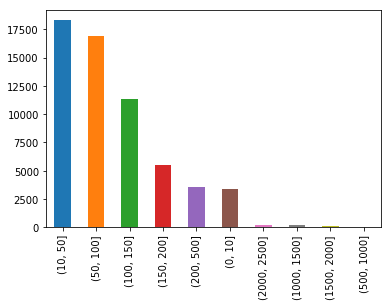

In [11]:
bins=[0,10,50,100,150,200,500,1000,1500,2000,2500]
df['Proximity to USAFB bins'] = pd.cut(new_df['Proximity to USAFB'],bins)
df['Proximity to USAFB bins'].value_counts().plot(kind='bar')

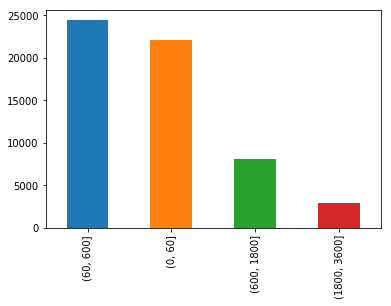

In [40]:
bins=[0,60,600,1800,3600]
df['duration (seconds) bins'] = pd.cut(df['duration (seconds)'],bins)
df['duration (seconds) bins'].value_counts().plot(kind='bar')

In [41]:
duration_label_heat = pd.crosstab(df['duration (seconds) bins'],df['label'])
total_label = duration_label_heat.apply(sum)
duration_label_heat/=total_label
duration_label_heat

label,0,1
duration (seconds) bins,,
"(0, 60]",0.386282,0.296909
"(60, 600]",0.427889,0.318433
"(600, 1800]",0.138725,0.211369
"(1800, 3600]",0.047104,0.173289


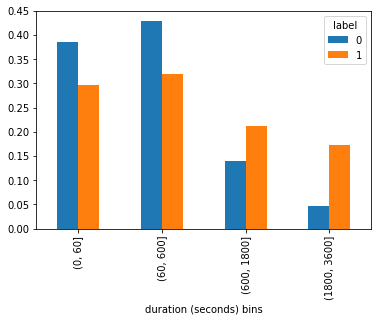

In [42]:
duration_label_heat.plot(kind='bar')

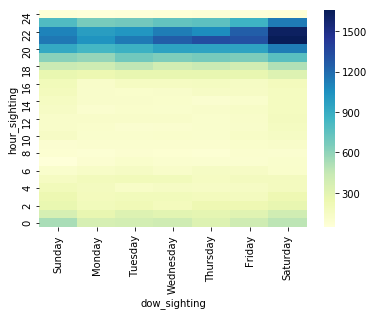

In [12]:
dow_hour_heat = pd.crosstab(new_df['hour_sighting'],new_df['dow_sighting']).iloc[::-1]
dow_hour_heat = dow_hour_heat[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']]
sns.heatmap(dow_hour_heat,cmap="YlGnBu")

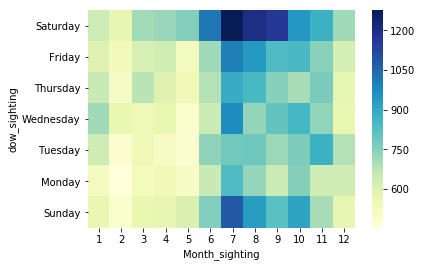

In [13]:
month_dow_heat = pd.crosstab(new_df['Month_sighting'],new_df['dow_sighting'])
month_dow_heat =month_dow_heat[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']].T.iloc[::-1]
sns.heatmap(month_dow_heat,cmap="YlGnBu")

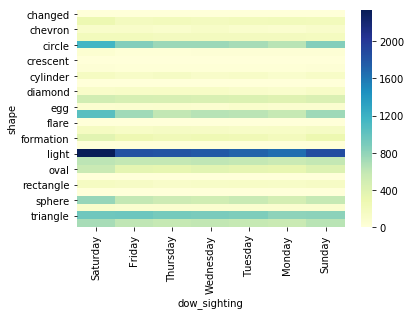

In [14]:
shape_dow_heat = pd.crosstab(new_df['shape'],new_df['dow_sighting'])
shape_dow_heat =shape_dow_heat[['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']].T.iloc[::-1]
sns.heatmap(shape_dow_heat.T,cmap="YlGnBu")

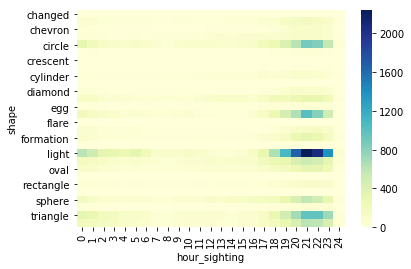

In [15]:
shape_hour_heat = pd.crosstab(new_df['shape'],new_df['hour_sighting'])
sns.heatmap(shape_hour_heat,cmap="YlGnBu")

#### Random Forest

In [43]:
features = ['state','shape','duration (seconds)','date_pd','time_pd','days_lapsed_after_sighting','dow_sighting','phase' ,'Extreme_Weather','Proximity to USAFB']

In [44]:
Y, X = dmatrices('label~0 + state + shape + Q("duration (seconds)") + date_pd + time_pd + days_lapsed_after_sighting + dow_sighting + phase + Extreme_Weather + Q("Proximity to USAFB")', new_df, return_type='dataframe')
y = Y['label'].values

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y,random_state=99)

In [72]:
sum(y_train == 0)

34543

In [46]:
from sklearn import ensemble
model = ensemble.RandomForestClassifier(random_state=99)
result = model.fit(X_train, y_train)

In [47]:
from sklearn import metrics

prediction_train = model.predict(X_train)
print metrics.accuracy_score(y_train, prediction_train)

0.9922363717605005


In [48]:
pd.crosstab(y_train,prediction_train,rownames=['Actual'],colnames=['Prediction'])

Prediction,0.0,1.0
Actual,,
0.0,34541,2
1.0,276,989


In [49]:
prediction_test = model.predict(X_test)
print metrics.accuracy_score(y_test, prediction_test)

0.9660285678381435


In [50]:
pd.crosstab(y_test,prediction_test,rownames=['Actual'],colnames=['Prediction'])

Prediction,0.0,1.0
Actual,,
0.0,22974,55
1.0,756,88


In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_test,prediction_test))

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98     23029
        1.0       0.62      0.10      0.18       844

avg / total       0.96      0.97      0.95     23873



#### Changing the threshold to 0.05

In [87]:
predicted_prob_train = model.predict_proba(X_train)
prediction_mine_train = (predicted_prob_train[:,1] > 0.05).astype(int)
print metrics.accuracy_score(y_train, prediction_mine_train)

0.9199061662198391


In [88]:
pd.crosstab(y_train,prediction_mine_train,rownames=['Actual'],colnames=['Prediction'])

Prediction,0,1
Actual,,
0.0,31675,2868
1.0,0,1265


In [89]:
predicted_prob_test = model.predict_proba(X_test)
prediction_mine_test = (predicted_prob_test[:,1] > 0.05).astype(int)
print metrics.accuracy_score(y_test, prediction_mine_test)

0.8038788589620073


In [85]:
pd.crosstab(y_test,prediction_mine_test,rownames=['Actual'],colnames=['Prediction'])

Prediction,0,1
Actual,,
0.0,18819,4210
1.0,472,372


In [84]:
from sklearn.metrics import classification_report
print(classification_report(y_test,prediction_mine_test))

             precision    recall  f1-score   support

        0.0       0.98      0.82      0.89     23029
        1.0       0.08      0.44      0.14       844

avg / total       0.94      0.80      0.86     23873



#### Feature Importances

In [73]:
sorted(list(zip(features, model.feature_importances_)),reverse=True, key = lambda x:x[1])

[('time_pd', 0.010399272839036914),
 ('Proximity to USAFB', 0.004347960496322176),
 ('date_pd', 0.0026049149937739354),
 ('days_lapsed_after_sighting', 0.0019576787144686787),
 ('duration (seconds)', 0.0013355463074406393),
 ('dow_sighting', 0.0012147916025091114),
 ('shape', 0.0010985982929795756),
 ('state', 0.0008996239437976835),
 ('Extreme_Weather', 0.00042136085542590813),
 ('phase', 1.5406750781684667e-06)]